In [2]:
import pandas as pd

FILE_PATH = "jeroen_punt_nl_dynamische_stroomprijzen_jaar_2024.csv"
FIXED_PRICE = 0.289   # €/kWh (fixed contract incl. taxes)
POWER_KW = 7.4        # charging power (1-phase wallbox)
CHARGE_START = 18     # start hour
CHARGE_END = 7        # end hour
TAX_SURCHARGE = 0.10880
BTW = 1.21

df = pd.read_csv(FILE_PATH, sep=";", decimal=",")
df["datum_nl"] = pd.to_datetime(df["datum_nl"])
df["hour"] = df["datum_nl"].dt.hour
df["weekday"] = df["datum_nl"].dt.day_name()

# apply btw and taxes
df["prijs_incl_belastingen"] = (df["prijs_excl_belastingen"] + TAX_SURCHARGE) * BTW


# function per scenario
def calculate_scenario(name, active_days, energy_kwh_per_day):
    needed_hours = int(energy_kwh_per_day / POWER_KW)

    # Select charging window between 18:00 and 07:00
    df_charge = df[(df["hour"] >= CHARGE_START) | (df["hour"] < CHARGE_END)].copy()

    # Keep only active days if applicable
    if active_days:
        df_charge = df_charge[df_charge["weekday"].isin(active_days)]

    # Select the *first hours after 18:00 each day*
    all_days = sorted(df_charge["datum_nl"].dt.date.unique())
    charged_rows = []

    for i in range(len(all_days) - 1):
        today = all_days[i]
        tomorrow = all_days[i + 1]

        # Combine hours 18:00–23:00 of today with 00:00–06:00 of next day
        window_today = df[(df["datum_nl"].dt.date == today) & (df["hour"] >= CHARGE_START)]
        window_next = df[(df["datum_nl"].dt.date == tomorrow) & (df["hour"] < CHARGE_END)]
        window = pd.concat([window_today, window_next]).sort_values("datum_nl")

        # Select the first needed_hours (immediate charging)
        charged_rows.append(window.iloc[:needed_hours])

    df_nonopt = pd.concat(charged_rows)

    # === Calculate costs ===
    df_nonopt["cost_dynamic"] = df_nonopt["prijs_incl_belastingen"] * POWER_KW
    df_nonopt["cost_fixed"] = FIXED_PRICE * POWER_KW

    daily_costs = df_nonopt.groupby(df_nonopt["datum_nl"].dt.date)[["cost_dynamic", "cost_fixed"]].sum()
    total_dynamic = daily_costs["cost_dynamic"].sum()
    total_fixed = daily_costs["cost_fixed"].sum()
    difference = total_dynamic - total_fixed

    return {
        "Scenario": name,
        "Active days": ", ".join(active_days) if active_days else "Every day",
        "Energy/day (kWh)": energy_kwh_per_day,
        "Total dynamic (€)": total_dynamic,
        "Total fixed (€)": total_fixed,
        "Difference (€)": difference
    }


scenarios = [
    ("Distant commuter", [], 29.6),                      # daily
    ("City hopper", [], 7.4),                            # daily
    ("Road tripper", ["Saturday", "Sunday"], 29.6),      # weekends
    ("Grocery grabber", ["Wednesday", "Sunday"], 7.4)    # twice per week
]

# results
results = [calculate_scenario(*s) for s in scenarios]
df_results = pd.DataFrame(results)

# save file
df_results.to_csv("scenario_costs_2024_nonoptimized.csv", index=False)
print("Results saved to 'scenario_costs_2024_nonoptimized.csv'")

# results printed
print(f"\n{'Scenario':<20} {'Active days':<25} {'Energy/day (kWh)':>17} "
      f"{'Total dynamic (€)':>20} {'Total fixed (€)':>20} {'Difference (€)':>20}")
print("-" * 125)

for r in results:
    print(f"{r['Scenario']:<20} {r['Active days']:<25} {r['Energy/day (kWh)']:>17.1f} "
          f"{r['Total dynamic (€)']:>20.2f} {r['Total fixed (€)']:>20.2f} {r['Difference (€)']:>20.2f}")



Results saved to 'scenario_costs_2024_nonoptimized.csv'

Scenario             Active days                Energy/day (kWh)    Total dynamic (€)      Total fixed (€)       Difference (€)
-----------------------------------------------------------------------------------------------------------------------------
Distant commuter     Every day                              29.6              2865.14              3122.36              -257.21
City hopper          Every day                               7.4               710.26               780.59               -70.33
Road tripper         Saturday, Sunday                       29.6               742.95               881.10              -138.15
Grocery grabber      Wednesday, Sunday                       7.4               196.12               220.28               -24.15


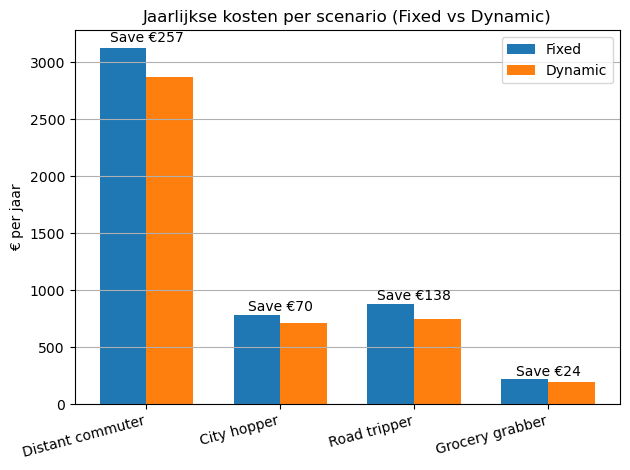

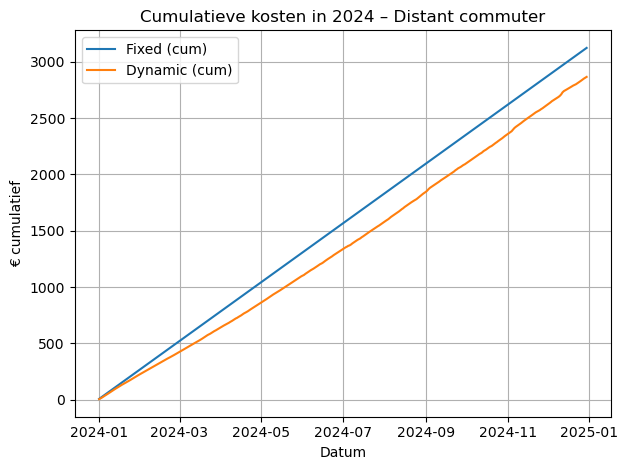

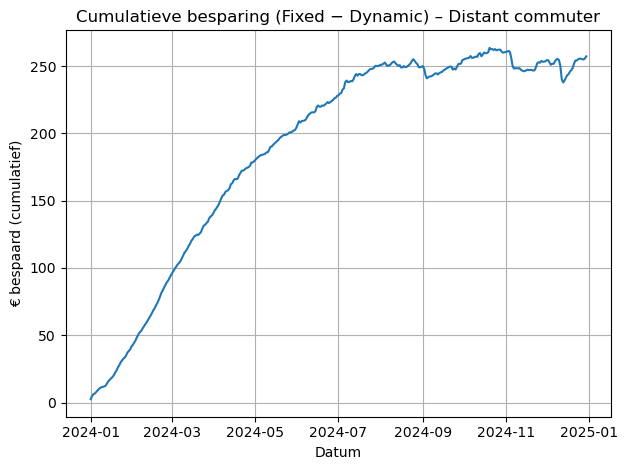

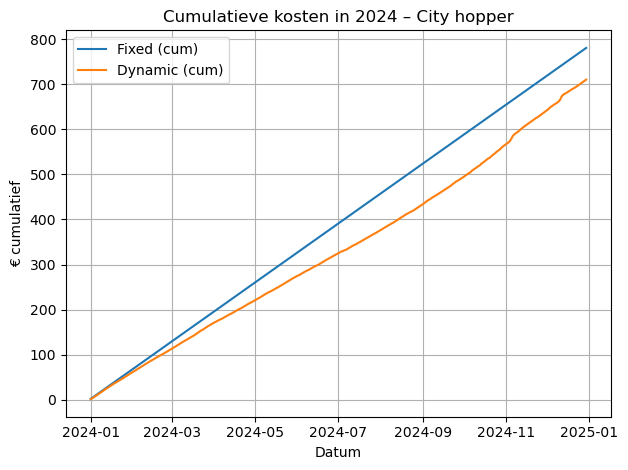

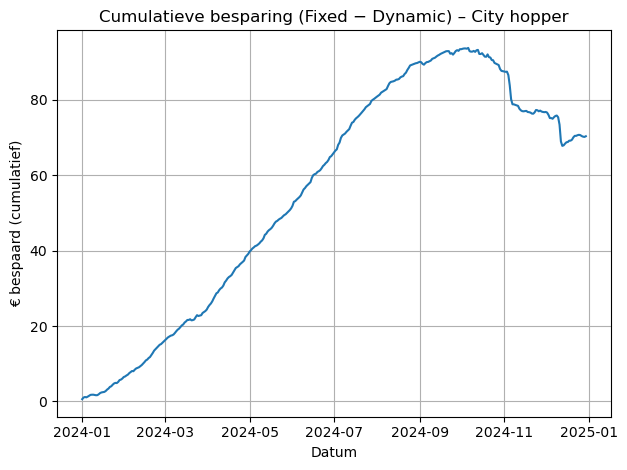

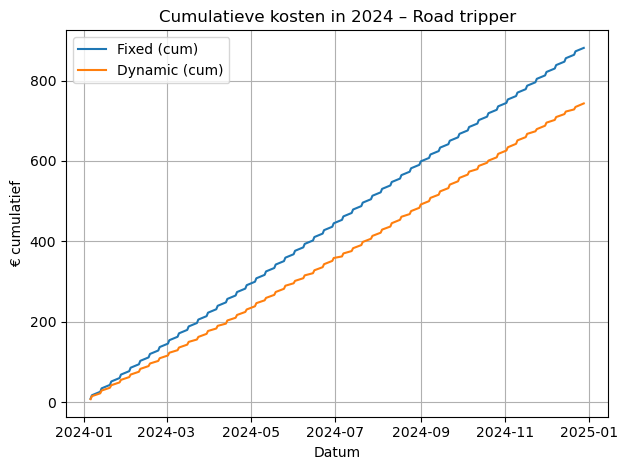

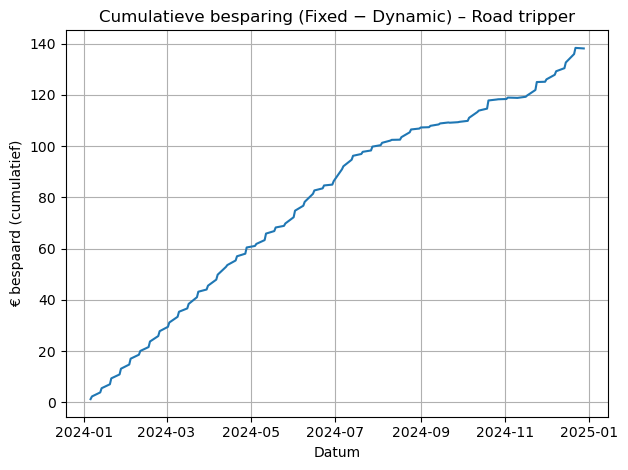

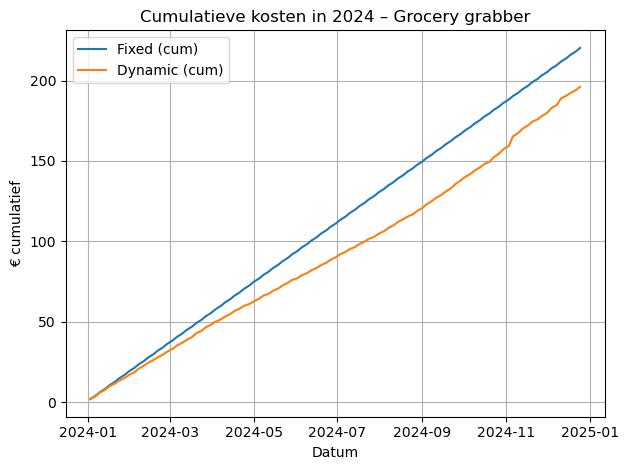

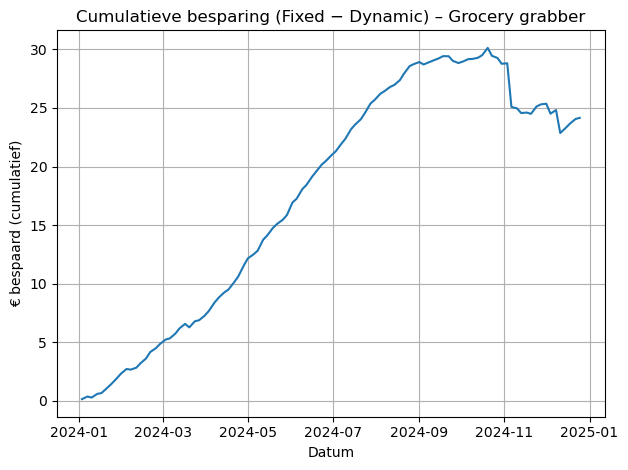

In [3]:
import numpy as np 
import matplotlib.pyplot as plt

# --- jouw bestaande constanten en df blijven gelijk ---

def calculate_scenario(name, active_days, energy_kwh_per_day):
    needed_hours = int(energy_kwh_per_day / POWER_KW)

    # Select charging window tussen 18:00 en 07:00
    df_charge = df[(df["hour"] >= CHARGE_START) | (df["hour"] < CHARGE_END)].copy()

    # Beperk tot actieve dagen (optioneel)
    if active_days:
        df_charge = df_charge[df_charge["weekday"].isin(active_days)]

    # Bepaal unieke dagen binnen laadvenster
    all_days = sorted(df_charge["datum_nl"].dt.date.unique())
    charged_rows = []

    # Loop over dagen en pak eerste 'needed_hours' na 18:00 tot 07:00
    for i in range(len(all_days) - 1):
        today = all_days[i]
        tomorrow = all_days[i + 1]

        window_today = df[(df["datum_nl"].dt.date == today) & (df["hour"] >= CHARGE_START)]
        window_next  = df[(df["datum_nl"].dt.date == tomorrow) & (df["hour"] < CHARGE_END)]
        window = pd.concat([window_today, window_next]).sort_values("datum_nl")

        if len(window) == 0:
            continue

        charged_rows.append(window.iloc[:needed_hours])

    if not charged_rows:
        # Geen data in het venster voor dit scenario
        return {
            "summary": {
                "Scenario": name,
                "Active days": ", ".join(active_days) if active_days else "Every day",
                "Energy/day (kWh)": energy_kwh_per_day,
                "Total dynamic (€)": 0.0,
                "Total fixed (€)": 0.0,
                "Difference (€)": 0.0
            },
            "daily": pd.DataFrame(columns=["date", "cost_dynamic", "cost_fixed"])
        }

    df_nonopt = pd.concat(charged_rows).copy()

    # Kosten per uur
    df_nonopt["cost_dynamic"] = df_nonopt["prijs_incl_belastingen"] * POWER_KW
    df_nonopt["cost_fixed"]   = FIXED_PRICE * POWER_KW

    # Dagelijkse kosten (key voor cumulatieve grafiek)
    daily_costs = df_nonopt.groupby(df_nonopt["datum_nl"].dt.date)[["cost_dynamic", "cost_fixed"]].sum().reset_index()
    daily_costs = daily_costs.rename(columns={"datum_nl": "date"})

    # Samenvatting
    total_dynamic = daily_costs["cost_dynamic"].sum()
    total_fixed   = daily_costs["cost_fixed"].sum()
    difference    = total_dynamic - total_fixed

    return {
        "summary": {
            "Scenario": name,
            "Active days": ", ".join(active_days) if active_days else "Every day",
            "Energy/day (kWh)": energy_kwh_per_day,
            "Total dynamic (€)": total_dynamic,
            "Total fixed (€)": total_fixed,
            "Difference (€)": difference
        },
        "daily": daily_costs.assign(scenario=name)  # handig voor concat
    }

# --- run scenarios ---
scenarios = [
    ("Distant commuter", [], 29.6),                      # daily
    ("City hopper", [], 7.4),                            # daily
    ("Road tripper", ["Saturday", "Sunday"], 29.6),      # weekends
    ("Grocery grabber", ["Wednesday", "Sunday"], 7.4)    # twice per week
]

results = [calculate_scenario(*s) for s in scenarios]
df_results = pd.DataFrame([r["summary"] for r in results])
df_daily   = pd.concat([r["daily"] for r in results], ignore_index=True)

# --- 1) Grouped bar: jaarlijkse kosten per scenario ---
def plot_grouped_bars(df_results):
    x = np.arange(len(df_results))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x - width/2, df_results["Total fixed (€)"],  width, label="Fixed")
    ax.bar(x + width/2, df_results["Total dynamic (€)"], width, label="Dynamic")

    ax.set_xticks(x)
    ax.set_xticklabels(df_results["Scenario"], rotation=15, ha="right")
    ax.set_ylabel("€ per jaar")
    ax.set_title("Jaarlijkse kosten per scenario (Fixed vs Dynamic)")
    ax.legend()
    ax.grid(True, axis="y")

    # labels voor besparing
    for i, row in df_results.iterrows():
        saving = row["Total fixed (€)"] - row["Total dynamic (€)"]
        y = max(row["Total fixed (€)"], row["Total dynamic (€)"])
        ax.text(i, y * 1.01, f"Save €{saving:,.0f}", ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

plot_grouped_bars(df_results)

# --- 2) Cumulatieve kosten over het jaar ---
def plot_cumulative_costs(df_daily, scenario_name):
    df_s = df_daily[df_daily["scenario"] == scenario_name].sort_values("date")
    df_s["cum_fixed"]   = df_s["cost_fixed"].cumsum()
    df_s["cum_dynamic"] = df_s["cost_dynamic"].cumsum()
    df_s["cum_saving"]  = df_s["cum_fixed"] - df_s["cum_dynamic"]

    fig, ax = plt.subplots()
    ax.plot(df_s["date"], df_s["cum_fixed"],   label="Fixed (cum)")
    ax.plot(df_s["date"], df_s["cum_dynamic"], label="Dynamic (cum)")
    ax.set_title(f"Cumulatieve kosten in 2024 – {scenario_name}")
    ax.set_xlabel("Datum")
    ax.set_ylabel("€ cumulatief")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Alternatief: alleen cumulatieve besparing
    fig, ax = plt.subplots()
    ax.plot(df_s["date"], df_s["cum_saving"])
    ax.set_title(f"Cumulatieve besparing (Fixed − Dynamic) – {scenario_name}")
    ax.set_xlabel("Datum")
    ax.set_ylabel("€ bespaard (cumulatief)")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# voorbeeld: plot voor alle scenario’s
for sc in df_results["Scenario"]:
    plot_cumulative_costs(df_daily, sc)